In [1]:
import logging
import os.path
import time
from collections import OrderedDict
import sys

import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch import optim
import torch as th
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn

from braindecode.models.deep4 import Deep4Net
from braindecode.models.util import to_dense_prediction_model
from braindecode.datasets.bcic_iv_2a import BCICompetition4Set2A
from braindecode.experiments.experiment import Experiment
from braindecode.experiments.monitors import LossMonitor, MisclassMonitor, \
    RuntimeMonitor, CroppedTrialMisclassMonitor
from braindecode.experiments.stopcriteria import MaxEpochs, NoDecrease, Or
from braindecode.datautil.iterators import CropsFromTrialsIterator
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from braindecode.datautil.splitters import split_into_two_sets
from braindecode.torch_ext.constraints import MaxNormDefaultConstraint
from braindecode.torch_ext.util import set_random_seeds, np_to_var
from braindecode.mne_ext.signalproc import mne_apply
from braindecode.datautil.signalproc import (bandpass_cnt,
                                             exponential_running_standardize)
from braindecode.datautil.trial_segment import create_signal_target_from_raw_mne

log = logging.getLogger(__name__)

In [2]:
def run_exp(data_folder, subject_id, low_cut_hz, model, cuda):
    ival = [-500, 4000]
    input_time_length = 1125
    max_epochs = 800
    max_increase_epochs = 80
    batch_size = 60
    high_cut_hz = 38
    factor_new = 1e-3
    init_block_size = 1000
    valid_set_fraction = 0.2

    train_filename = 'A{:02d}T.gdf'.format(subject_id)
    test_filename = 'A{:02d}E.gdf'.format(subject_id)
    train_filepath = os.path.join(data_folder, train_filename)
    test_filepath = os.path.join(data_folder, test_filename)
    train_label_filepath = train_filepath.replace('.gdf', '.mat')
    test_label_filepath = test_filepath.replace('.gdf', '.mat')

    train_loader = BCICompetition4Set2A(
        train_filepath, labels_filename=train_label_filepath)
    test_loader = BCICompetition4Set2A(
        test_filepath, labels_filename=test_label_filepath)
    train_cnt = train_loader.load()
    test_cnt = test_loader.load()

    # Preprocessing

    train_cnt = train_cnt.drop_channels(['STI 014', 'EOG-left',
                                         'EOG-central', 'EOG-right'])
    assert len(train_cnt.ch_names) == 22
    # lets convert to millvolt for numerical stability of next operations
    train_cnt = mne_apply(lambda a: a * 1e6, train_cnt)
    train_cnt = mne_apply(
        lambda a: bandpass_cnt(a, low_cut_hz, high_cut_hz, train_cnt.info['sfreq'],
                               filt_order=3,
                               axis=1), train_cnt)
    train_cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=factor_new,
                                                  init_block_size=init_block_size,
                                                  eps=1e-4).T,
        train_cnt)

    test_cnt = test_cnt.drop_channels(['STI 014', 'EOG-left',
                                       'EOG-central', 'EOG-right'])
    assert len(test_cnt.ch_names) == 22
    test_cnt = mne_apply(lambda a: a * 1e6, test_cnt)
    test_cnt = mne_apply(
        lambda a: bandpass_cnt(a, low_cut_hz, high_cut_hz, test_cnt.info['sfreq'],
                               filt_order=3,
                               axis=1), test_cnt)
    test_cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=factor_new,
                                                  init_block_size=init_block_size,
                                                  eps=1e-4).T,
        test_cnt)

    marker_def = OrderedDict([('Left Hand', [1]), ('Right Hand', [2],),
                              ('Foot', [3]), ('Tongue', [4])])

    train_set = create_signal_target_from_raw_mne(train_cnt, marker_def, ival)
    test_set = create_signal_target_from_raw_mne(test_cnt, marker_def, ival)

    train_set, valid_set = split_into_two_sets(
        train_set, first_set_fraction=1-valid_set_fraction)

    set_random_seeds(seed=20190706, cuda=cuda)

    n_classes = 4
    n_chans = int(train_set.X.shape[1])
    if model == 'shallow':
        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length=input_time_length,
                            final_conv_length=30).create_network()
    elif model == 'deep':
        model = Deep4Net(n_chans, n_classes, input_time_length=input_time_length,
                            final_conv_length=2).create_network()


    to_dense_prediction_model(model)
    if cuda:
        model.cuda()

    log.info("Model: \n{:s}".format(str(model)))
    dummy_input = np_to_var(train_set.X[:1, :, :, None])
    if cuda:
        dummy_input = dummy_input.cuda()
    out = model(dummy_input)

    n_preds_per_input = out.cpu().data.numpy().shape[2]

    optimizer = optim.Adam(model.parameters())

    iterator = CropsFromTrialsIterator(batch_size=batch_size,
                                       input_time_length=input_time_length,
                                       n_preds_per_input=n_preds_per_input)

    stop_criterion = Or([MaxEpochs(max_epochs),
                         NoDecrease('valid_misclass', max_increase_epochs)])

    monitors = [LossMonitor(), MisclassMonitor(col_suffix='sample_misclass'),
                CroppedTrialMisclassMonitor(
                    input_time_length=input_time_length), RuntimeMonitor()]

    model_constraint = MaxNormDefaultConstraint()

    loss_function = lambda preds, targets: F.nll_loss(
        th.mean(preds, dim=2, keepdim=False), targets)

    exp = Experiment(model, train_set, valid_set, test_set, iterator=iterator,
                     loss_function=loss_function, optimizer=optimizer,
                     model_constraint=model_constraint,
                     monitors=monitors,
                     stop_criterion=stop_criterion,
                     remember_best_column='valid_misclass',
                     run_after_early_stop=True, cuda=cuda)
    exp.run()
    return exp

# Running Shallow Model

In [3]:
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                    level=logging.DEBUG, stream=sys.stdout)
# Should contain both .gdf files and .mat-labelfiles from competition
data_folder = '/home/david/data/BCICIV_2a_gdf/'
subject_id = 1 # 1-9
low_cut_hz = 4 # 0 or 4
model = 'shallow' #'shallow' or 'deep'
cuda = True
exp = run_exp(data_folder, subject_id, low_cut_hz, model, cuda)
log.info("Last 10 epochs")
log.info("\n" + str(exp.epochs_df.iloc[-10:]))

Extracting EDF parameters from /home/david/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Overlapping events detected. Use find_edf_events for the original events.
Setting channel info structure...
Interpolating stim channel. Events may jitter.
Creating raw.info structure...
Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/mne/io/edf/edf.py:1028: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running num

Extracting EDF parameters from /home/david/data/BCICIV_2a_gdf/A01E.gdf...
GDF file detected
Overlapping events detected. Use find_edf_events for the original events.
Setting channel info structure...
Interpolating stim channel. Events may jitter.
Creating raw.info structure...
Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/mne/io/edf/edf.py:1028: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running num

2018-10-01 19:53:01,822 INFO : Trial per class:
Counter({'Tongue': 72, 'Foot': 72, 'Right Hand': 72, 'Left Hand': 72})
2018-10-01 19:53:02,061 INFO : Trial per class:
Counter({'Left Hand': 72, 'Right Hand': 72, 'Foot': 72, 'Tongue': 72})
2018-10-01 19:53:03,640 INFO : Model: 
Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5)
  (conv_classifier): Conv2d(40, 4, kernel_size=(30, 1), stride=(1, 1), dilation=(15, 1))
  (softmax): LogSoftmax()
  (squeeze): Expression(expression=_squeeze_final_output)
)
2018-10-01 19:53:03,644 INFO : Run until first stop

2018-10-01 19:53:06,161 INFO : 
2018-10-01 19:53:06,165 INFO : New best valid_misclass: 0.637931
2018-10-01 19:53:06,165 INFO : 
2018-10-01 19:53:06,285 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:06,459 INFO : Epoch 9
2018-10-01 19:53:06,459 INFO : train_loss                0.97442
2018-10-01 19:53:06,460 INFO : valid_loss                1.31445
2018-10-01 19:53:06,460 INFO : test_loss                 1.16214
2018-10-01 19:53:06,460 INFO : train_sample_misclass     0.39459
2018-10-01 19:53:06,460 INFO : valid_sample_misclass     0.54741
2018-10-01 19:53:06,461 INFO : test_sample_misclass      0.45056
2018-10-01 19:53:06,461 INFO : train_misclass            0.38261
2018-10-01 19:53:06,461 INFO : valid_misclass            0.53448
2018-10-01 19:53:06,461 INFO : test_misclass             0.42014
2018-10-01 19:53:06,462 INFO : runtime                   0.31713
2018-10-01 19:53:06,462 INFO : 
2018-10-01 19:53:06,466 INFO : New best valid_misclass: 0.534483
2018-10-01 19:53

2018-10-01 19:53:09,093 INFO : valid_misclass            0.22414
2018-10-01 19:53:09,093 INFO : test_misclass             0.30556
2018-10-01 19:53:09,093 INFO : runtime                   0.29479
2018-10-01 19:53:09,094 INFO : 
2018-10-01 19:53:09,097 INFO : New best valid_misclass: 0.224138
2018-10-01 19:53:09,097 INFO : 
2018-10-01 19:53:09,214 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:09,383 INFO : Epoch 19
2018-10-01 19:53:09,384 INFO : train_loss                0.42021
2018-10-01 19:53:09,384 INFO : valid_loss                0.78783
2018-10-01 19:53:09,384 INFO : test_loss                 0.75851
2018-10-01 19:53:09,384 INFO : train_sample_misclass     0.15086
2018-10-01 19:53:09,385 INFO : valid_sample_misclass     0.34477
2018-10-01 19:53:09,385 INFO : test_sample_misclass      0.36845
2018-10-01 19:53:09,385 INFO : train_misclass            0.09130
2018-10-01 19:53:09,386 INFO : valid_misclass            0.29310
2018-10-01 19:53:09,386 INFO : test_misclass   

2018-10-01 19:53:12,027 INFO : runtime                   0.27555
2018-10-01 19:53:12,027 INFO : 
2018-10-01 19:53:12,145 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:12,303 INFO : Epoch 29
2018-10-01 19:53:12,304 INFO : train_loss                0.28928
2018-10-01 19:53:12,304 INFO : valid_loss                0.75585
2018-10-01 19:53:12,304 INFO : test_loss                 0.65914
2018-10-01 19:53:12,305 INFO : train_sample_misclass     0.05679
2018-10-01 19:53:12,305 INFO : valid_sample_misclass     0.29762
2018-10-01 19:53:12,305 INFO : test_sample_misclass      0.28862
2018-10-01 19:53:12,305 INFO : train_misclass            0.02174
2018-10-01 19:53:12,306 INFO : valid_misclass            0.25862
2018-10-01 19:53:12,306 INFO : test_misclass             0.22917
2018-10-01 19:53:12,306 INFO : runtime                   0.28107
2018-10-01 19:53:12,306 INFO : 
2018-10-01 19:53:12,422 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:12,580 INFO : Epoch 30
201

2018-10-01 19:53:15,168 INFO : test_loss                 0.61156
2018-10-01 19:53:15,168 INFO : train_sample_misclass     0.03635
2018-10-01 19:53:15,169 INFO : valid_sample_misclass     0.33134
2018-10-01 19:53:15,169 INFO : test_sample_misclass      0.25368
2018-10-01 19:53:15,169 INFO : train_misclass            0.00000
2018-10-01 19:53:15,169 INFO : valid_misclass            0.25862
2018-10-01 19:53:15,170 INFO : test_misclass             0.19792
2018-10-01 19:53:15,170 INFO : runtime                   0.28502
2018-10-01 19:53:15,170 INFO : 
2018-10-01 19:53:15,292 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:15,455 INFO : Epoch 40
2018-10-01 19:53:15,455 INFO : train_loss                0.23055
2018-10-01 19:53:15,456 INFO : valid_loss                0.70067
2018-10-01 19:53:15,456 INFO : test_loss                 0.60973
2018-10-01 19:53:15,456 INFO : train_sample_misclass     0.03387
2018-10-01 19:53:15,456 INFO : valid_sample_misclass     0.28638
2018-10-01 19:

2018-10-01 19:53:18,038 INFO : valid_loss                0.66317
2018-10-01 19:53:18,039 INFO : test_loss                 0.56138
2018-10-01 19:53:18,039 INFO : train_sample_misclass     0.02064
2018-10-01 19:53:18,039 INFO : valid_sample_misclass     0.27845
2018-10-01 19:53:18,040 INFO : test_sample_misclass      0.23070
2018-10-01 19:53:18,040 INFO : train_misclass            0.00000
2018-10-01 19:53:18,040 INFO : valid_misclass            0.18966
2018-10-01 19:53:18,041 INFO : test_misclass             0.18056
2018-10-01 19:53:18,041 INFO : runtime                   0.28290
2018-10-01 19:53:18,041 INFO : 
2018-10-01 19:53:18,045 INFO : New best valid_misclass: 0.189655
2018-10-01 19:53:18,045 INFO : 
2018-10-01 19:53:18,161 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:18,320 INFO : Epoch 50
2018-10-01 19:53:18,321 INFO : train_loss                0.20466
2018-10-01 19:53:18,321 INFO : valid_loss                0.69662
2018-10-01 19:53:18,321 INFO : test_loss       

2018-10-01 19:53:20,899 INFO : train_sample_misclass     0.01644
2018-10-01 19:53:20,899 INFO : valid_sample_misclass     0.28084
2018-10-01 19:53:20,899 INFO : test_sample_misclass      0.22228
2018-10-01 19:53:20,900 INFO : train_misclass            0.00000
2018-10-01 19:53:20,900 INFO : valid_misclass            0.18966
2018-10-01 19:53:20,900 INFO : test_misclass             0.18056
2018-10-01 19:53:20,901 INFO : runtime                   0.28606
2018-10-01 19:53:20,901 INFO : 
2018-10-01 19:53:21,021 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:21,185 INFO : Epoch 60
2018-10-01 19:53:21,185 INFO : train_loss                0.19151
2018-10-01 19:53:21,186 INFO : valid_loss                0.63863
2018-10-01 19:53:21,186 INFO : test_loss                 0.61573
2018-10-01 19:53:21,186 INFO : train_sample_misclass     0.02172
2018-10-01 19:53:21,187 INFO : valid_sample_misclass     0.25160
2018-10-01 19:53:21,187 INFO : test_sample_misclass      0.26145
2018-10-01 19:

2018-10-01 19:53:23,821 INFO : test_misclass             0.16667
2018-10-01 19:53:23,821 INFO : runtime                   0.29556
2018-10-01 19:53:23,822 INFO : 
2018-10-01 19:53:23,825 INFO : New best valid_misclass: 0.137931
2018-10-01 19:53:23,825 INFO : 
2018-10-01 19:53:23,946 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:24,110 INFO : Epoch 70
2018-10-01 19:53:24,110 INFO : train_loss                0.16757
2018-10-01 19:53:24,110 INFO : valid_loss                0.63510
2018-10-01 19:53:24,111 INFO : test_loss                 0.55155
2018-10-01 19:53:24,111 INFO : train_sample_misclass     0.01381
2018-10-01 19:53:24,111 INFO : valid_sample_misclass     0.26712
2018-10-01 19:53:24,112 INFO : test_sample_misclass      0.22045
2018-10-01 19:53:24,112 INFO : train_misclass            0.00000
2018-10-01 19:53:24,112 INFO : valid_misclass            0.20690
2018-10-01 19:53:24,113 INFO : test_misclass             0.17014
2018-10-01 19:53:24,113 INFO : runtime         

2018-10-01 19:53:26,994 INFO : Epoch 80
2018-10-01 19:53:26,994 INFO : train_loss                0.15342
2018-10-01 19:53:26,995 INFO : valid_loss                0.63020
2018-10-01 19:53:26,995 INFO : test_loss                 0.54270
2018-10-01 19:53:26,995 INFO : train_sample_misclass     0.00891
2018-10-01 19:53:26,995 INFO : valid_sample_misclass     0.26145
2018-10-01 19:53:26,996 INFO : test_sample_misclass      0.21932
2018-10-01 19:53:26,996 INFO : train_misclass            0.00000
2018-10-01 19:53:26,996 INFO : valid_misclass            0.18966
2018-10-01 19:53:26,997 INFO : test_misclass             0.14931
2018-10-01 19:53:26,997 INFO : runtime                   0.28688
2018-10-01 19:53:26,997 INFO : 
2018-10-01 19:53:27,112 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:27,270 INFO : Epoch 81
2018-10-01 19:53:27,270 INFO : train_loss                0.16989
2018-10-01 19:53:27,271 INFO : valid_loss                0.64430
2018-10-01 19:53:27,271 INFO : test_los

2018-10-01 19:53:29,833 INFO : train_sample_misclass     0.00772
2018-10-01 19:53:29,833 INFO : valid_sample_misclass     0.23349
2018-10-01 19:53:29,833 INFO : test_sample_misclass      0.21574
2018-10-01 19:53:29,834 INFO : train_misclass            0.00000
2018-10-01 19:53:29,834 INFO : valid_misclass            0.17241
2018-10-01 19:53:29,834 INFO : test_misclass             0.17361
2018-10-01 19:53:29,835 INFO : runtime                   0.28389
2018-10-01 19:53:29,835 INFO : 
2018-10-01 19:53:29,963 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:30,126 INFO : Epoch 91
2018-10-01 19:53:30,127 INFO : train_loss                0.13593
2018-10-01 19:53:30,127 INFO : valid_loss                0.61407
2018-10-01 19:53:30,127 INFO : test_loss                 0.51092
2018-10-01 19:53:30,128 INFO : train_sample_misclass     0.00790
2018-10-01 19:53:30,128 INFO : valid_sample_misclass     0.26005
2018-10-01 19:53:30,128 INFO : test_sample_misclass      0.19911
2018-10-01 19:

2018-10-01 19:53:32,732 INFO : test_sample_misclass      0.20471
2018-10-01 19:53:32,732 INFO : train_misclass            0.00000
2018-10-01 19:53:32,732 INFO : valid_misclass            0.12069
2018-10-01 19:53:32,732 INFO : test_misclass             0.14931
2018-10-01 19:53:32,733 INFO : runtime                   0.29617
2018-10-01 19:53:32,733 INFO : 
2018-10-01 19:53:32,736 INFO : New best valid_misclass: 0.120690
2018-10-01 19:53:32,736 INFO : 
2018-10-01 19:53:32,862 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:33,022 INFO : Epoch 101
2018-10-01 19:53:33,023 INFO : train_loss                0.12879
2018-10-01 19:53:33,023 INFO : valid_loss                0.58761
2018-10-01 19:53:33,023 INFO : test_loss                 0.51994
2018-10-01 19:53:33,024 INFO : train_sample_misclass     0.00674
2018-10-01 19:53:33,024 INFO : valid_sample_misclass     0.24799
2018-10-01 19:53:33,024 INFO : test_sample_misclass      0.20951
2018-10-01 19:53:33,025 INFO : train_misclass 

2018-10-01 19:53:35,613 INFO : test_sample_misclass      0.21128
2018-10-01 19:53:35,613 INFO : train_misclass            0.00000
2018-10-01 19:53:35,614 INFO : valid_misclass            0.13793
2018-10-01 19:53:35,614 INFO : test_misclass             0.15625
2018-10-01 19:53:35,615 INFO : runtime                   0.28773
2018-10-01 19:53:35,615 INFO : 
2018-10-01 19:53:35,737 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:35,898 INFO : Epoch 111
2018-10-01 19:53:35,898 INFO : train_loss                0.14443
2018-10-01 19:53:35,899 INFO : valid_loss                0.59815
2018-10-01 19:53:35,899 INFO : test_loss                 0.55292
2018-10-01 19:53:35,900 INFO : train_sample_misclass     0.01116
2018-10-01 19:53:35,900 INFO : valid_sample_misclass     0.23695
2018-10-01 19:53:35,900 INFO : test_sample_misclass      0.23718
2018-10-01 19:53:35,901 INFO : train_misclass            0.00000
2018-10-01 19:53:35,901 INFO : valid_misclass            0.15517
2018-10-01 19

2018-10-01 19:53:38,482 INFO : 
2018-10-01 19:53:38,601 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:38,762 INFO : Epoch 121
2018-10-01 19:53:38,762 INFO : train_loss                0.14643
2018-10-01 19:53:38,763 INFO : valid_loss                0.61742
2018-10-01 19:53:38,763 INFO : test_loss                 0.55286
2018-10-01 19:53:38,763 INFO : train_sample_misclass     0.01183
2018-10-01 19:53:38,763 INFO : valid_sample_misclass     0.25676
2018-10-01 19:53:38,764 INFO : test_sample_misclass      0.23110
2018-10-01 19:53:38,764 INFO : train_misclass            0.00000
2018-10-01 19:53:38,764 INFO : valid_misclass            0.17241
2018-10-01 19:53:38,765 INFO : test_misclass             0.17708
2018-10-01 19:53:38,765 INFO : runtime                   0.28394
2018-10-01 19:53:38,765 INFO : 
2018-10-01 19:53:38,886 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:39,049 INFO : Epoch 122
2018-10-01 19:53:39,050 INFO : train_loss                0.15365
2

2018-10-01 19:53:41,639 INFO : Epoch 131
2018-10-01 19:53:41,640 INFO : train_loss                0.12186
2018-10-01 19:53:41,640 INFO : valid_loss                0.57161
2018-10-01 19:53:41,640 INFO : test_loss                 0.52672
2018-10-01 19:53:41,641 INFO : train_sample_misclass     0.00743
2018-10-01 19:53:41,641 INFO : valid_sample_misclass     0.24831
2018-10-01 19:53:41,641 INFO : test_sample_misclass      0.21151
2018-10-01 19:53:41,641 INFO : train_misclass            0.00000
2018-10-01 19:53:41,642 INFO : valid_misclass            0.20690
2018-10-01 19:53:41,642 INFO : test_misclass             0.16667
2018-10-01 19:53:41,642 INFO : runtime                   0.28841
2018-10-01 19:53:41,643 INFO : 
2018-10-01 19:53:41,767 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:41,931 INFO : Epoch 132
2018-10-01 19:53:41,932 INFO : train_loss                0.13882
2018-10-01 19:53:41,932 INFO : valid_loss                0.59701
2018-10-01 19:53:41,932 INFO : test_l

2018-10-01 19:53:44,652 INFO : train_sample_misclass     0.00399
2018-10-01 19:53:44,653 INFO : valid_sample_misclass     0.21636
2018-10-01 19:53:44,653 INFO : test_sample_misclass      0.19373
2018-10-01 19:53:44,653 INFO : train_misclass            0.00000
2018-10-01 19:53:44,654 INFO : valid_misclass            0.08621
2018-10-01 19:53:44,654 INFO : test_misclass             0.13889
2018-10-01 19:53:44,654 INFO : runtime                   0.31472
2018-10-01 19:53:44,655 INFO : 
2018-10-01 19:53:44,778 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:44,955 INFO : Epoch 142
2018-10-01 19:53:44,955 INFO : train_loss                0.11806
2018-10-01 19:53:44,955 INFO : valid_loss                0.55944
2018-10-01 19:53:44,956 INFO : test_loss                 0.51825
2018-10-01 19:53:44,956 INFO : train_sample_misclass     0.00635
2018-10-01 19:53:44,956 INFO : valid_sample_misclass     0.23191
2018-10-01 19:53:44,957 INFO : test_sample_misclass      0.20508
2018-10-01 19

2018-10-01 19:53:47,696 INFO : test_misclass             0.13194
2018-10-01 19:53:47,697 INFO : runtime                   0.30981
2018-10-01 19:53:47,697 INFO : 
2018-10-01 19:53:47,820 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:47,989 INFO : Epoch 152
2018-10-01 19:53:47,990 INFO : train_loss                0.10599
2018-10-01 19:53:47,990 INFO : valid_loss                0.53152
2018-10-01 19:53:47,990 INFO : test_loss                 0.50661
2018-10-01 19:53:47,991 INFO : train_sample_misclass     0.00303
2018-10-01 19:53:47,991 INFO : valid_sample_misclass     0.20885
2018-10-01 19:53:47,991 INFO : test_sample_misclass      0.19437
2018-10-01 19:53:47,992 INFO : train_misclass            0.00000
2018-10-01 19:53:47,992 INFO : valid_misclass            0.10345
2018-10-01 19:53:47,992 INFO : test_misclass             0.14236
2018-10-01 19:53:47,993 INFO : runtime                   0.29723
2018-10-01 19:53:47,993 INFO : 
2018-10-01 19:53:48,112 INFO : Time only for t

2018-10-01 19:53:50,814 INFO : valid_loss                0.57021
2018-10-01 19:53:50,814 INFO : test_loss                 0.58126
2018-10-01 19:53:50,814 INFO : train_sample_misclass     0.01214
2018-10-01 19:53:50,814 INFO : valid_sample_misclass     0.23867
2018-10-01 19:53:50,815 INFO : test_sample_misclass      0.23622
2018-10-01 19:53:50,815 INFO : train_misclass            0.00000
2018-10-01 19:53:50,815 INFO : valid_misclass            0.22414
2018-10-01 19:53:50,816 INFO : test_misclass             0.20139
2018-10-01 19:53:50,816 INFO : runtime                   0.27469
2018-10-01 19:53:50,816 INFO : 
2018-10-01 19:53:50,931 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:51,089 INFO : Epoch 163
2018-10-01 19:53:51,090 INFO : train_loss                0.10676
2018-10-01 19:53:51,090 INFO : valid_loss                0.53507
2018-10-01 19:53:51,090 INFO : test_loss                 0.50802
2018-10-01 19:53:51,091 INFO : train_sample_misclass     0.00267
2018-10-01 19

2018-10-01 19:53:53,570 INFO : train_misclass            0.00000
2018-10-01 19:53:53,571 INFO : valid_misclass            0.10345
2018-10-01 19:53:53,571 INFO : test_misclass             0.14583
2018-10-01 19:53:53,571 INFO : runtime                   0.27655
2018-10-01 19:53:53,572 INFO : 
2018-10-01 19:53:53,686 INFO : Time only for training updates: 0.09s
2018-10-01 19:53:53,842 INFO : Epoch 173
2018-10-01 19:53:53,843 INFO : train_loss                0.09352
2018-10-01 19:53:53,843 INFO : valid_loss                0.50871
2018-10-01 19:53:53,843 INFO : test_loss                 0.48976
2018-10-01 19:53:53,843 INFO : train_sample_misclass     0.00260
2018-10-01 19:53:53,844 INFO : valid_sample_misclass     0.20497
2018-10-01 19:53:53,844 INFO : test_sample_misclass      0.18628
2018-10-01 19:53:53,844 INFO : train_misclass            0.00000
2018-10-01 19:53:53,845 INFO : valid_misclass            0.12069
2018-10-01 19:53:53,845 INFO : test_misclass             0.13542
2018-10-01 19

2018-10-01 19:53:56,535 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:56,710 INFO : Epoch 183
2018-10-01 19:53:56,711 INFO : train_loss                0.09559
2018-10-01 19:53:56,711 INFO : valid_loss                0.50933
2018-10-01 19:53:56,712 INFO : test_loss                 0.50300
2018-10-01 19:53:56,712 INFO : train_sample_misclass     0.00346
2018-10-01 19:53:56,713 INFO : valid_sample_misclass     0.21182
2018-10-01 19:53:56,713 INFO : test_sample_misclass      0.19100
2018-10-01 19:53:56,713 INFO : train_misclass            0.00000
2018-10-01 19:53:56,713 INFO : valid_misclass            0.13793
2018-10-01 19:53:56,714 INFO : test_misclass             0.14583
2018-10-01 19:53:56,714 INFO : runtime                   0.29517
2018-10-01 19:53:56,714 INFO : 
2018-10-01 19:53:56,837 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:57,002 INFO : Epoch 184
2018-10-01 19:53:57,003 INFO : train_loss                0.09507
2018-10-01 19:53:57,003 INFO : va

2018-10-01 19:53:59,511 INFO : train_sample_misclass     0.00471
2018-10-01 19:53:59,511 INFO : valid_sample_misclass     0.20020
2018-10-01 19:53:59,511 INFO : test_sample_misclass      0.20961
2018-10-01 19:53:59,512 INFO : train_misclass            0.00000
2018-10-01 19:53:59,512 INFO : valid_misclass            0.08621
2018-10-01 19:53:59,512 INFO : test_misclass             0.15278
2018-10-01 19:53:59,513 INFO : runtime                   0.27723
2018-10-01 19:53:59,513 INFO : 
2018-10-01 19:53:59,636 INFO : Time only for training updates: 0.10s
2018-10-01 19:53:59,799 INFO : Epoch 194
2018-10-01 19:53:59,800 INFO : train_loss                0.11403
2018-10-01 19:53:59,800 INFO : valid_loss                0.57327
2018-10-01 19:53:59,800 INFO : test_loss                 0.52360
2018-10-01 19:53:59,801 INFO : train_sample_misclass     0.00613
2018-10-01 19:53:59,801 INFO : valid_sample_misclass     0.23864
2018-10-01 19:53:59,801 INFO : test_sample_misclass      0.21230
2018-10-01 19

2018-10-01 19:54:02,381 INFO : test_misclass             0.12847
2018-10-01 19:54:02,381 INFO : runtime                   0.28599
2018-10-01 19:54:02,382 INFO : 
2018-10-01 19:54:02,503 INFO : Time only for training updates: 0.10s
2018-10-01 19:54:02,663 INFO : Epoch 204
2018-10-01 19:54:02,664 INFO : train_loss                0.09256
2018-10-01 19:54:02,664 INFO : valid_loss                0.52598
2018-10-01 19:54:02,664 INFO : test_loss                 0.48657
2018-10-01 19:54:02,664 INFO : train_sample_misclass     0.00213
2018-10-01 19:54:02,665 INFO : valid_sample_misclass     0.20419
2018-10-01 19:54:02,665 INFO : test_sample_misclass      0.17975
2018-10-01 19:54:02,665 INFO : train_misclass            0.00000
2018-10-01 19:54:02,666 INFO : valid_misclass            0.10345
2018-10-01 19:54:02,666 INFO : test_misclass             0.12153
2018-10-01 19:54:02,666 INFO : runtime                   0.28713
2018-10-01 19:54:02,666 INFO : 
2018-10-01 19:54:02,783 INFO : Time only for t

2018-10-01 19:54:05,168 INFO : Run until second stop...
2018-10-01 19:54:05,357 INFO : Epoch 134
2018-10-01 19:54:05,357 INFO : train_loss                0.21647
2018-10-01 19:54:05,357 INFO : valid_loss                0.57032
2018-10-01 19:54:05,358 INFO : test_loss                 0.52596
2018-10-01 19:54:05,358 INFO : train_sample_misclass     0.04980
2018-10-01 19:54:05,358 INFO : valid_sample_misclass     0.22262
2018-10-01 19:54:05,359 INFO : test_sample_misclass      0.21515
2018-10-01 19:54:05,359 INFO : train_misclass            0.01389
2018-10-01 19:54:05,359 INFO : valid_misclass            0.06897
2018-10-01 19:54:05,359 INFO : test_misclass             0.15972
2018-10-01 19:54:05,360 INFO : runtime                   0.18027
2018-10-01 19:54:05,360 INFO : 
2018-10-01 19:54:05,363 INFO : New best valid_misclass: 0.068966
2018-10-01 19:54:05,363 INFO : 
2018-10-01 19:54:05,513 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:05,685 INFO : Epoch 135
2018-10-01 19:

2018-10-01 19:54:08,431 INFO : train_misclass            0.00347
2018-10-01 19:54:08,431 INFO : valid_misclass            0.01724
2018-10-01 19:54:08,432 INFO : test_misclass             0.18403
2018-10-01 19:54:08,432 INFO : runtime                   0.36418
2018-10-01 19:54:08,432 INFO : 
2018-10-01 19:54:08,589 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:08,771 INFO : Epoch 144
2018-10-01 19:54:08,771 INFO : train_loss                0.21775
2018-10-01 19:54:08,771 INFO : valid_loss                0.33763
2018-10-01 19:54:08,772 INFO : test_loss                 0.66925
2018-10-01 19:54:08,772 INFO : train_sample_misclass     0.05081
2018-10-01 19:54:08,772 INFO : valid_sample_misclass     0.12835
2018-10-01 19:54:08,773 INFO : test_sample_misclass      0.28636
2018-10-01 19:54:08,773 INFO : train_misclass            0.01389
2018-10-01 19:54:08,773 INFO : valid_misclass            0.06897
2018-10-01 19:54:08,773 INFO : test_misclass             0.24306
2018-10-01 19

2018-10-01 19:54:11,727 INFO : test_sample_misclass      0.23203
2018-10-01 19:54:11,728 INFO : train_misclass            0.00347
2018-10-01 19:54:11,728 INFO : valid_misclass            0.01724
2018-10-01 19:54:11,728 INFO : test_misclass             0.20833
2018-10-01 19:54:11,728 INFO : runtime                   0.32402
2018-10-01 19:54:11,729 INFO : 
2018-10-01 19:54:11,877 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:12,049 INFO : Epoch 154
2018-10-01 19:54:12,050 INFO : train_loss                0.15997
2018-10-01 19:54:12,050 INFO : valid_loss                0.23127
2018-10-01 19:54:12,050 INFO : test_loss                 0.52179
2018-10-01 19:54:12,051 INFO : train_sample_misclass     0.01750
2018-10-01 19:54:12,051 INFO : valid_sample_misclass     0.05094
2018-10-01 19:54:12,051 INFO : test_sample_misclass      0.20419
2018-10-01 19:54:12,052 INFO : train_misclass            0.00000
2018-10-01 19:54:12,052 INFO : valid_misclass            0.00000
2018-10-01 19

2018-10-01 19:54:14,668 INFO : 
2018-10-01 19:54:14,818 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:14,991 INFO : Epoch 163
2018-10-01 19:54:14,992 INFO : train_loss                0.16338
2018-10-01 19:54:14,992 INFO : valid_loss                0.22065
2018-10-01 19:54:14,993 INFO : test_loss                 0.54358
2018-10-01 19:54:14,993 INFO : train_sample_misclass     0.02039
2018-10-01 19:54:14,993 INFO : valid_sample_misclass     0.04604
2018-10-01 19:54:14,994 INFO : test_sample_misclass      0.22876
2018-10-01 19:54:14,994 INFO : train_misclass            0.00000
2018-10-01 19:54:14,994 INFO : valid_misclass            0.00000
2018-10-01 19:54:14,995 INFO : test_misclass             0.19792
2018-10-01 19:54:14,995 INFO : runtime                   0.32538
2018-10-01 19:54:14,995 INFO : 
2018-10-01 19:54:14,998 INFO : New best valid_misclass: 0.000000
2018-10-01 19:54:14,999 INFO : 
2018-10-01 19:54:15,145 INFO : Time only for training updates: 0.12s
2018-10-01

2018-10-01 19:54:17,958 INFO : valid_loss                0.17914
2018-10-01 19:54:17,958 INFO : test_loss                 0.50170
2018-10-01 19:54:17,958 INFO : train_sample_misclass     0.00966
2018-10-01 19:54:17,958 INFO : valid_sample_misclass     0.02583
2018-10-01 19:54:17,959 INFO : test_sample_misclass      0.20013
2018-10-01 19:54:17,959 INFO : train_misclass            0.00000
2018-10-01 19:54:17,959 INFO : valid_misclass            0.00000
2018-10-01 19:54:17,960 INFO : test_misclass             0.15278
2018-10-01 19:54:17,960 INFO : runtime                   0.32706
2018-10-01 19:54:17,961 INFO : 
2018-10-01 19:54:17,963 INFO : New best valid_misclass: 0.000000
2018-10-01 19:54:17,964 INFO : 
2018-10-01 19:54:18,111 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:18,287 INFO : Epoch 173
2018-10-01 19:54:18,287 INFO : train_loss                0.12996
2018-10-01 19:54:18,288 INFO : valid_loss                0.17314
2018-10-01 19:54:18,288 INFO : test_loss      

2018-10-01 19:54:20,979 INFO : valid_sample_misclass     0.02007
2018-10-01 19:54:20,979 INFO : test_sample_misclass      0.19553
2018-10-01 19:54:20,980 INFO : train_misclass            0.00000
2018-10-01 19:54:20,980 INFO : valid_misclass            0.00000
2018-10-01 19:54:20,980 INFO : test_misclass             0.15278
2018-10-01 19:54:20,981 INFO : runtime                   0.34270
2018-10-01 19:54:20,981 INFO : 
2018-10-01 19:54:20,984 INFO : New best valid_misclass: 0.000000
2018-10-01 19:54:20,984 INFO : 
2018-10-01 19:54:21,133 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:21,307 INFO : Epoch 182
2018-10-01 19:54:21,307 INFO : train_loss                0.11875
2018-10-01 19:54:21,308 INFO : valid_loss                0.15606
2018-10-01 19:54:21,308 INFO : test_loss                 0.48137
2018-10-01 19:54:21,308 INFO : train_sample_misclass     0.00606
2018-10-01 19:54:21,308 INFO : valid_sample_misclass     0.01421
2018-10-01 19:54:21,309 INFO : test_sample_mis

2018-10-01 19:54:23,972 INFO : valid_misclass            0.00000
2018-10-01 19:54:23,973 INFO : test_misclass             0.15972
2018-10-01 19:54:23,973 INFO : runtime                   0.33853
2018-10-01 19:54:23,973 INFO : 
2018-10-01 19:54:23,976 INFO : New best valid_misclass: 0.000000
2018-10-01 19:54:23,977 INFO : 
2018-10-01 19:54:24,125 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:24,301 INFO : Epoch 191
2018-10-01 19:54:24,301 INFO : train_loss                0.11582
2018-10-01 19:54:24,302 INFO : valid_loss                0.14182
2018-10-01 19:54:24,302 INFO : test_loss                 0.47253
2018-10-01 19:54:24,302 INFO : train_sample_misclass     0.00437
2018-10-01 19:54:24,302 INFO : valid_sample_misclass     0.00682
2018-10-01 19:54:24,303 INFO : test_sample_misclass      0.18088
2018-10-01 19:54:24,303 INFO : train_misclass            0.00000
2018-10-01 19:54:24,303 INFO : valid_misclass            0.00000
2018-10-01 19:54:24,303 INFO : test_misclass  

2018-10-01 19:54:27,006 INFO : 
2018-10-01 19:54:27,009 INFO : New best valid_misclass: 0.000000
2018-10-01 19:54:27,009 INFO : 
2018-10-01 19:54:27,155 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:27,333 INFO : Epoch 200
2018-10-01 19:54:27,333 INFO : train_loss                0.12422
2018-10-01 19:54:27,334 INFO : valid_loss                0.15780
2018-10-01 19:54:27,334 INFO : test_loss                 0.47419
2018-10-01 19:54:27,334 INFO : train_sample_misclass     0.00683
2018-10-01 19:54:27,334 INFO : valid_sample_misclass     0.01308
2018-10-01 19:54:27,335 INFO : test_sample_misclass      0.19437
2018-10-01 19:54:27,335 INFO : train_misclass            0.00000
2018-10-01 19:54:27,335 INFO : valid_misclass            0.00000
2018-10-01 19:54:27,335 INFO : test_misclass             0.14583
2018-10-01 19:54:27,336 INFO : runtime                   0.32775
2018-10-01 19:54:27,336 INFO : 
2018-10-01 19:54:27,339 INFO : New best valid_misclass: 0.000000
2018-10-01 19:

2018-10-01 19:54:30,369 INFO : train_sample_misclass     0.00941
2018-10-01 19:54:30,369 INFO : valid_sample_misclass     0.01753
2018-10-01 19:54:30,369 INFO : test_sample_misclass      0.19990
2018-10-01 19:54:30,370 INFO : train_misclass            0.00000
2018-10-01 19:54:30,370 INFO : valid_misclass            0.00000
2018-10-01 19:54:30,370 INFO : test_misclass             0.13889
2018-10-01 19:54:30,370 INFO : runtime                   0.33196
2018-10-01 19:54:30,371 INFO : 
2018-10-01 19:54:30,373 INFO : New best valid_misclass: 0.000000
2018-10-01 19:54:30,374 INFO : 
2018-10-01 19:54:30,525 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:30,699 INFO : Epoch 210
2018-10-01 19:54:30,700 INFO : train_loss                0.11060
2018-10-01 19:54:30,700 INFO : valid_loss                0.12830
2018-10-01 19:54:30,700 INFO : test_loss                 0.47956
2018-10-01 19:54:30,701 INFO : train_sample_misclass     0.00438
2018-10-01 19:54:30,701 INFO : valid_sample_mi

2018-10-01 19:54:33,382 INFO : train_misclass            0.00000
2018-10-01 19:54:33,382 INFO : valid_misclass            0.00000
2018-10-01 19:54:33,382 INFO : test_misclass             0.18750
2018-10-01 19:54:33,382 INFO : runtime                   0.32440
2018-10-01 19:54:33,383 INFO : 
2018-10-01 19:54:33,386 INFO : New best valid_misclass: 0.000000
2018-10-01 19:54:33,386 INFO : 
2018-10-01 19:54:33,533 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:33,704 INFO : Epoch 219
2018-10-01 19:54:33,705 INFO : train_loss                0.16727
2018-10-01 19:54:33,705 INFO : valid_loss                0.19340
2018-10-01 19:54:33,706 INFO : test_loss                 0.64485
2018-10-01 19:54:33,706 INFO : train_sample_misclass     0.02806
2018-10-01 19:54:33,706 INFO : valid_sample_misclass     0.03276
2018-10-01 19:54:33,707 INFO : test_sample_misclass      0.26649
2018-10-01 19:54:33,707 INFO : train_misclass            0.00347
2018-10-01 19:54:33,707 INFO : valid_misclass 

2018-10-01 19:54:36,369 INFO : runtime                   0.32495
2018-10-01 19:54:36,370 INFO : 
2018-10-01 19:54:36,373 INFO : New best valid_misclass: 0.000000
2018-10-01 19:54:36,373 INFO : 
2018-10-01 19:54:36,522 INFO : Time only for training updates: 0.12s
2018-10-01 19:54:36,695 INFO : Epoch 228
2018-10-01 19:54:36,695 INFO : train_loss                0.11249
2018-10-01 19:54:36,695 INFO : valid_loss                0.13843
2018-10-01 19:54:36,696 INFO : test_loss                 0.46089
2018-10-01 19:54:36,696 INFO : train_sample_misclass     0.00571
2018-10-01 19:54:36,696 INFO : valid_sample_misclass     0.01413
2018-10-01 19:54:36,697 INFO : test_sample_misclass      0.17663
2018-10-01 19:54:36,697 INFO : train_misclass            0.00000
2018-10-01 19:54:36,698 INFO : valid_misclass            0.00000
2018-10-01 19:54:36,698 INFO : test_misclass             0.12500
2018-10-01 19:54:36,698 INFO : runtime                   0.33326
2018-10-01 19:54:36,699 INFO : 
2018-10-01 19:

# Explain

In [4]:
exp.epochs_df.tail(5)

,train_loss,valid_loss,test_loss,train_sample_misclass,valid_sample_misclass,test_sample_misclass,train_misclass,valid_misclass,test_misclass,runtime
231,0.108672,0.129494,0.465701,0.003678,0.005767,0.179224,0.0,0.0,0.125000,0.365038
232,0.105517,0.127623,0.460117,0.003437,0.004747,0.176116,0.0,0.0,0.114583,0.324602
233,0.107052,0.131778,0.467159,0.005795,0.012523,0.179852,0.0,0.0,0.121528,0.324899
234,0.109922,0.131456,0.464096,0.004070,0.007135,0.178198,0.0,0.0,0.125000,0.338254
235,0.105095,0.124937,0.481799,0.004962,0.010805,0.187365,0.0,0.0,0.138889,0.325918


In [5]:
exp.model

Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5)
  (conv_classifier): Conv2d(40, 4, kernel_size=(30, 1), stride=(1, 1), dilation=(15, 1))
  (softmax): LogSoftmax()
  (squeeze): Expression(expression=_squeeze_final_output)
)

# Save Model

In [15]:
filepath = "models/model_cropped_{}_A0{:d}_{}.pt" . format(model, subject_id, low_cut_hz)

th.save(exp.model, filepath)

In [9]:
def batch_predict(experiment, dataset='test', is_target_cropped=True):
    all_actual = []
    all_predicted = []
    for batch in experiment.iterator.get_batches(experiment.datasets[dataset], shuffle=False):

        feature_vars = np_to_var(batch[0], pin_memory = experiment.pin_memory)
        target_vars = np_to_var(batch[1], pin_memory = experiment.pin_memory)

        if experiment.cuda:
            feature_vars = feature_vars.cuda()
            target_vars = target_vars.cuda()

        outputs = experiment.model(feature_vars)

        if hasattr(outputs, 'cpu'):
            outputs = outputs.cpu().data.numpy()
        else:
            # assume it is iterable
            outputs = [o.cpu().data.numpy() for o in outputs]

        if hasattr(target_vars, 'cpu'):
            target_vars = target_vars.cpu().data.numpy()
        else:
            # assume it is iterable
            target_vars = [o.cpu().data.numpy() for o in target_vars]

        predicted_vars = np.argmax(outputs, axis=1).squeeze()

        all_actual += target_vars.tolist()
        all_predicted += predicted_vars.tolist()
    
    
    if is_target_cropped:
        new_all_predicted = []
        for y in all_predicted:
            (values, counts) = np.unique(y, return_counts=True)
            ind = np.argmax(counts)
            new_all_predicted.append(values[ind])
        all_predicted = new_all_predicted
        
    return all_actual, all_predicted

In [10]:
test_target_actual, test_target_predicted = batch_predict(exp, 'test', is_target_cropped=True)

In [11]:
all_classes = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']

test_actual = [all_classes[i] for i in test_target_actual]
test_predicted = [all_classes[i] for i in test_target_predicted]

kappa_score = metrics.cohen_kappa_score(test_actual, test_predicted, labels=all_classes)
confusion_metric = metrics.confusion_matrix(test_actual, test_predicted, labels=all_classes)
clf_rep = metrics.precision_recall_fscore_support(test_actual, test_predicted)

score_dict = {
    "precision": clf_rep[0].round(2), 
    "recall": clf_rep[1].round(2), 
    "f1-score": clf_rep[2].round(2), 
    "support": clf_rep[3]
}

score_df = pd.DataFrame(score_dict, index=np.sort(all_classes))

In [12]:
import itertools

def plot_confusion_matrix(confusion_matrix, classes, title, xlabel, ylabel, width=5, height=4, cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(width, height), dpi=80)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()

2018-10-01 19:55:12,551 DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-10-01 19:55:12,608 DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


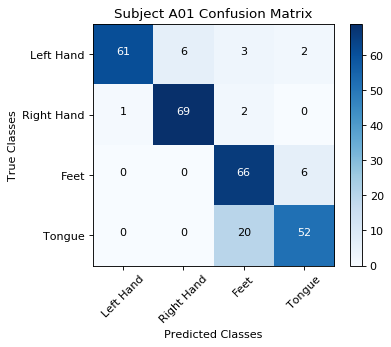

In [13]:
plot_confusion_matrix(confusion_metric, all_classes, title='Subject A0{:d} Confusion Matrix'.format(subject_id), xlabel='Predicted Classes', ylabel='True Classes')

In [14]:
score_df

,precision,recall,f1-score,support
Feet,0.73,0.92,0.81,72
Left Hand,0.98,0.85,0.91,72
Right Hand,0.92,0.96,0.94,72
Tongue,0.87,0.72,0.79,72
